In [1]:
import os
import re
import glob
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from typing import List, Dict, Tuple

# Menggunakan pdfminer.six, pastikan sudah terinstal: pip install pdfminer.six
from pdfminer.high_level import extract_text

# Menggunakan scikit-learn, pastikan sudah terinstal: pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- KONFIGURASI GLOBAL ---
PDF_FOLDER = 'Putusan'
LOG_FOLDER = 'logs'
DATA_FOLDER = 'data'
MODEL_FOLDER = 'models'

# Membuat semua direktori yang dibutuhkan
os.makedirs(LOG_FOLDER, exist_ok=True)
os.makedirs(MODEL_FOLDER, exist_ok=True)
os.makedirs(os.path.join(DATA_FOLDER, 'raw'), exist_ok=True)
os.makedirs(os.path.join(DATA_FOLDER, 'processed'), exist_ok=True)
os.makedirs(os.path.join(DATA_FOLDER, 'results'), exist_ok=True)
os.makedirs(os.path.join(DATA_FOLDER, 'eval'), exist_ok=True)

print("Konfigurasi dan pustaka berhasil dimuat.")
print("Folder yang diperlukan telah disiapkan.")

Konfigurasi dan pustaka berhasil dimuat.
Folder yang diperlukan telah disiapkan.


In [2]:
def clean_text_from_pdf(text: str) -> Tuple[str, float]:
    """Membersihkan teks dari noise seperti header, footer, dan disclaimer."""
    baseline_length = len(text)
    if baseline_length == 0:
        return "", 0.0

    boilerplate = [
        "Direktori Putusan Mahkamah Agung Republik Indonesia",
        "putusan.mahkamahagung.go.id",
        "M a h ka m a h A g u n g R e p u blik In d o n esia",
        "Disclaimer", "Kepaniteraan Mahkamah Agung Republik Indonesia",
        "Email : kepaniteraan@mahkamahagung.go.id"
    ]
    text = re.sub(r'halaman\s*\d+\s*dari\s*\d+', '', text, flags=re.IGNORECASE)
    for item in boilerplate:
        text = re.sub(re.escape(item), '', text, flags=re.IGNORECASE)

    cleaned_text = ' '.join(text.split()).lower()
    ratio = len(cleaned_text) / baseline_length
    return cleaned_text, ratio

def run_stage_1_cleaning():
    """Membaca semua PDF, membersihkan, dan menyimpannya sebagai file .txt."""
    print("="*50 + "\nMemulai Tahap 1: Pembangunan Case Base\n" + "="*50)
    
    pdf_files = sorted(glob.glob(os.path.join(PDF_FOLDER, '*.pdf')))
    log_file = os.path.join(LOG_FOLDER, '1_cleaning.log')
    raw_folder = os.path.join(DATA_FOLDER, 'raw')
    
    valid_files_count = 0
    with open(log_file, 'w', encoding='utf-8') as log:
        for i, pdf_path in enumerate(pdf_files):
            case_id = f"case_{i+1:03d}"
            try:
                raw_text = extract_text(pdf_path)
                cleaned_text, ratio = clean_text_from_pdf(raw_text)
                
                if ratio > 0.50:
                    with open(os.path.join(raw_folder, f"{case_id}.txt"), 'w', encoding='utf-8') as f:
                        f.write(cleaned_text)
                    status, valid_files_count = "[OK]", valid_files_count + 1
                else:
                    status = "[WARNING]"
                
                message = f"{status} {case_id} ({os.path.basename(pdf_path)}) diproses, rasio: {ratio:.2%}."
                print(message)
                log.write(f"[{datetime.now().isoformat()}] {message}\n")
            except Exception as e:
                message = f"[ERROR] Gagal memproses {pdf_path}: {e}"
                print(message)
                log.write(f"[{datetime.now().isoformat()}] {message}\n")

    print(f"\n[SUKSES] Tahap 1 Selesai. {valid_files_count} dari {len(pdf_files)} file valid disimpan di {raw_folder}")

# Jalankan Tahap 1
run_stage_1_cleaning()

Memulai Tahap 1: Pembangunan Case Base
[OK] case_001 (putusan_10_pid.b_2019_pn_wgw_20250624163132.pdf) diproses, rasio: 93.42%.
[OK] case_002 (putusan_10_pid.b_2021_pn_wgw_20250624163705.pdf) diproses, rasio: 93.29%.
[OK] case_003 (putusan_14_pid.b_2023_pn_wgw_20250624164349.pdf) diproses, rasio: 93.52%.
[OK] case_004 (putusan_15_pid.b_2023_pn_wgw_20250624164356.pdf) diproses, rasio: 93.36%.
[OK] case_005 (putusan_16_pid.b_2021_pn_wgw_20250624163639.pdf) diproses, rasio: 93.44%.
[OK] case_006 (putusan_22_pid.b_2022_pn_wgw_20250624164133.pdf) diproses, rasio: 93.29%.
[OK] case_007 (putusan_23_pid.b_2022_pn_wgw_20250624164330.pdf) diproses, rasio: 93.20%.
[OK] case_008 (putusan_24_pid.b_2022_pn_wgw_20250624164324.pdf) diproses, rasio: 93.38%.
[OK] case_009 (putusan_25_pid.b_2022_pn_wgw_20250624164148.pdf) diproses, rasio: 93.29%.
[OK] case_010 (putusan_28_pid.b_2020_pn_wgw_20250624163512.pdf) diproses, rasio: 92.03%.
[OK] case_011 (putusan_30_pid.b_2021_pn_wgw_20250624163646.pdf) diprose

In [7]:
def find_first_match(pattern: str, text: str) -> str:
    """Mencari dan mengembalikan hasil pertama dari pola regex."""
    try:
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        # --- PERBAIKAN DI SINI ---
        # Cek jika match.group(1) ada isinya sebelum memanggil .split()
        if match and match.group(1):
            return ' '.join(match.group(1).split())
        return ""
        # --- AKHIR PERBAIKAN ---
    except re.error:
        return ""

def extract_case_data(case_id: str, text: str) -> Dict:
    """Mengekstrak data terstruktur dari teks putusan menggunakan Regex."""
    no_perkara = find_first_match(r'putusan\s+nomor\s+([\w./-]+)', text)
    tanggal = find_first_match(r'pada\s+hari\s+\w+,\s+tanggal\s+([\d\s\w]+)\s+oleh', text)
    
    ringkasan_fakta = find_first_match(r'dakwaan\s+penuntut\s+umum\s+sebagai\s+berikut\s*:\s*(.*?)(?=menimbang,)', text)
    if not ringkasan_fakta: 
        ringkasan_fakta = find_first_match(r'surat\s+dakwaan\s+sebagai\s+berikut\s*:\s*(.*?)(?=menimbang,)', text)
    
    # Menggunakan satu grup penangkap utama untuk kedua pola 'pasal'
    pasal = find_first_match(r'((?:pasal\s+\d+\s+ayat\s+\(\d+\)\s+ke-\d+\s+kuhp)|(?:pasal\s+\d+\s+kuhp))', text)

    terdakwa = find_first_match(r'nama\s*lengkap\s*:\s*([a-z\s\d\.]+)\s*tempat', text)
    amar_putusan = find_first_match(r'm\s*e\s*n\s*g\s*a\s*d\s*i\s*l\s*i\s*:(.*?)(?=demikian\s+diputuskan)', text)

    return {
        "case_id": case_id, "no_perkara": no_perkara, "tanggal_putusan": tanggal,
        "terdakwa": terdakwa.title(), "pasal_utama": pasal, "ringkasan_fakta": ringkasan_fakta,
        "amar_putusan": amar_putusan, "text_full": text
    }

def run_stage_2_representation():
    """Membaca file .txt, mengekstrak data terstruktur, dan menyimpannya."""
    print("\n" + "="*50 + "\nMemulai Tahap 2: Representasi Kasus\n" + "="*50)
    raw_files = sorted(glob.glob(os.path.join(DATA_FOLDER, 'raw', '*.txt')))
    all_cases = [extract_case_data(os.path.splitext(os.path.basename(p))[0], open(p, 'r', encoding='utf-8').read()) for p in raw_files]
    df = pd.DataFrame(all_cases)
    
    df['ringkasan_fakta_len'] = df['ringkasan_fakta'].apply(lambda x: len(str(x).split()))
    df = df[df['ringkasan_fakta_len'] > 20].drop(columns=['ringkasan_fakta_len']).reset_index(drop=True)

    csv_output = os.path.join(DATA_FOLDER, 'processed', 'cases_extracted.csv')
    json_output = os.path.join(DATA_FOLDER, 'processed', 'cases_extracted.json')
    df.to_csv(csv_output, index=False)
    df.to_json(json_output, orient='records', indent=4)
    
    print(f"[SUKSES] Tahap 2 Selesai. {len(df)} kasus valid diekstrak.")
    print(f"Data disimpan di:\n- {csv_output}\n- {json_output}")
    return df

# Jalankan Tahap 2 dan tampilkan 5 baris pertama hasilnya
df_processed = run_stage_2_representation()
if not df_processed.empty:
    display(df_processed.head())
else:
    print("\n[ERROR] Tidak ada data valid untuk melanjutkan ke tahap berikutnya.")


Memulai Tahap 2: Representasi Kasus
[SUKSES] Tahap 2 Selesai. 30 kasus valid diekstrak.
Data disimpan di:
- data\processed\cases_extracted.csv
- data\processed\cases_extracted.json


,case_id,no_perkara,tanggal_putusan,terdakwa,pasal_utama,ringkasan_fakta,amar_putusan,text_full
0,case_001,10/pid.b/2019/pn,11 februari 2019,,pasal 363 ayat (1) ke-3 kuhp,primair bahwa terdakwa wa ode nuriana alias an...,,mahkamah agung republik indonesia mahkamah agu...
1,case_004,15/pid.b/2023/pn,,,pasal 362 kuhp,dakwaan pertama bahwa terdakwa putra arif prib...,,mahkamah agung republik indonesia mahkamah agu...
2,case_005,16/pid.b/2021/pn,,,pasal 363 ayat (1) ke-3 kuhp,bahwa ia terdakwa rizky hidayat alias iis bin ...,,mahkamah agung republik indonesia mahkamah agu...
3,case_007,23/pid.b/2022/pn,,,,bahwa terdakwa azhar alias indra bin la rabiu ...,,mahkamah agung republik indonesia mahkamah agu...
4,case_009,25/pid.b/2022/pn,18 agustus 2022,,pasal 64 kuhp,bahwa terdakwa sudir bin la supadi bersama – s...,,mahkamah agung republik indonesia mahkamah agu...


In [8]:
def run_stage_3_retrieval(df: pd.DataFrame):
    """Membagi data, melatih Vectorizer dan model SVM, lalu menyimpannya."""
    if df.empty:
        print("[ERROR] DataFrame kosong, tidak dapat melatih model.")
        return None, None
        
    print("\n" + "="*50 + "\nMemulai Tahap 3: Case Retrieval (Pelatihan Model)\n" + "="*50)
    df['ringkasan_fakta'].fillna('', inplace=True)
    X, y = df['ringkasan_fakta'], df['case_id']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))
    vectorizer.fit(X)
    
    svm_classifier = LinearSVC(random_state=42, dual=True)
    svm_classifier.fit(vectorizer.transform(X_train), y_train)

    vectorizer_path = os.path.join(MODEL_FOLDER, 'tfidf_vectorizer.pkl')
    svm_model_path = os.path.join(MODEL_FOLDER, 'svm_classifier.pkl')
    joblib.dump(vectorizer, vectorizer_path)
    joblib.dump(svm_classifier, svm_model_path)
    
    print("[SUKSES] Tahap 3 Selesai. Model telah dilatih dan disimpan.")
    return vectorizer, svm_classifier

# Jalankan Tahap 3
vectorizer, svm_classifier = run_stage_3_retrieval(df_processed)


Memulai Tahap 3: Case Retrieval (Pelatihan Model)
[SUKSES] Tahap 3 Selesai. Model telah dilatih dan disimpan.


C:\Users\rabba\AppData\Local\Temp\ipykernel_40052\1118655477.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ringkasan_fakta'].fillna('', inplace=True)


In [9]:
def retrieve_with_cosine(query: str, vectorizer: TfidfVectorizer, df: pd.DataFrame, k: int = 5) -> List[str]:
    all_vectors = vectorizer.transform(df['ringkasan_fakta'])
    query_vector = vectorizer.transform([query])
    similarities = cosine_similarity(query_vector, all_vectors).flatten()
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return df['case_id'].iloc[top_k_indices].tolist()

def retrieve_with_svm(query: str, vectorizer: TfidfVectorizer, model: LinearSVC) -> List[str]:
    return model.predict(vectorizer.transform([query])).tolist()

def run_stage_4_reuse(df: pd.DataFrame, vectorizer: TfidfVectorizer, svm_classifier: LinearSVC):
    if df.empty or vectorizer is None:
        print("[ERROR] Data atau model tidak siap untuk prediksi.")
        return
        
    print("\n" + "="*50 + "\nMemulai Tahap 4: Solution Reuse (Prediksi Solusi)\n" + "="*50)
    
    # Membuat query uji secara dinamis dari data yang ada
    np.random.seed(42)
    sample_indices = np.random.choice(df.index, size=min(10, len(df)), replace=False)
    sample_queries = [{"query": df.loc[i, 'ringkasan_fakta'][:200] + "...", "ground_truth": [df.loc[i, 'case_id']]} for i in sample_indices]
    
    eval_queries_path = os.path.join(DATA_FOLDER, 'eval', 'queries.json')
    with open(eval_queries_path, 'w') as f: json.dump(sample_queries, f, indent=4)
        
    case_solution_map = df.set_index('case_id')['amar_putusan'].to_dict()
    predictions_cosine, predictions_svm = [], []

    for i, item in enumerate(sample_queries):
        query = item["query"]
        retrieved_ids_cosine = retrieve_with_cosine(query, vectorizer, df)
        retrieved_ids_svm = retrieve_with_svm(query, vectorizer, svm_classifier)
        
        predictions_cosine.append({"query_id": i + 1, "query": query, "predicted_solution": case_solution_map.get(retrieved_ids_cosine[0]), "retrieved_case_ids": retrieved_ids_cosine})
        predictions_svm.append({"query_id": i + 1, "query": query, "predicted_solution": case_solution_map.get(retrieved_ids_svm[0]), "retrieved_case_ids": retrieved_ids_svm})

    cosine_csv_path = os.path.join(DATA_FOLDER, 'results', 'predictions_cosine.csv')
    svm_csv_path = os.path.join(DATA_FOLDER, 'results', 'predictions_svm.csv')
    pd.DataFrame(predictions_cosine).to_csv(cosine_csv_path, index=False)
    pd.DataFrame(predictions_svm).to_csv(svm_csv_path, index=False)
    
    print("[SUKSES] Tahap 4 Selesai. Hasil prediksi disimpan.")
    print("Contoh prediksi Cosine:")
    display(pd.DataFrame(predictions_cosine).head(3))

# Jalankan Tahap 4
run_stage_4_reuse(df_processed, vectorizer, svm_classifier)


Memulai Tahap 4: Solution Reuse (Prediksi Solusi)
[SUKSES] Tahap 4 Selesai. Hasil prediksi disimpan.
Contoh prediksi Cosine:


,query_id,query,predicted_solution,retrieved_case_ids
0,1,dakwaan bahwa terdakwa iksan bin muhajir bersa...,1.menyatakan terdakwa iksan bin muhajir terseb...,"[case_032, case_029, case_031, case_030, case_..."
1,2,primairbahwa terdakwa la ode rino alias rino b...,,"[case_020, case_024, case_019, case_026, case_..."
2,3,primair ----------- bahwa terdakwa suparman al...,1. menyatakan terdakwa suparman alias la bode ...,"[case_028, case_021, case_022, case_015, case_..."



Memulai Tahap 5: Evaluasi Model
--- Hasil Evaluasi ---


,model,accuracy,precision,recall,f1_score
0,TF-IDF + Cosine,1.0,1.0,1.0,1.000000
1,TF-IDF + SVM,0.4,1.0,0.4,0.571429


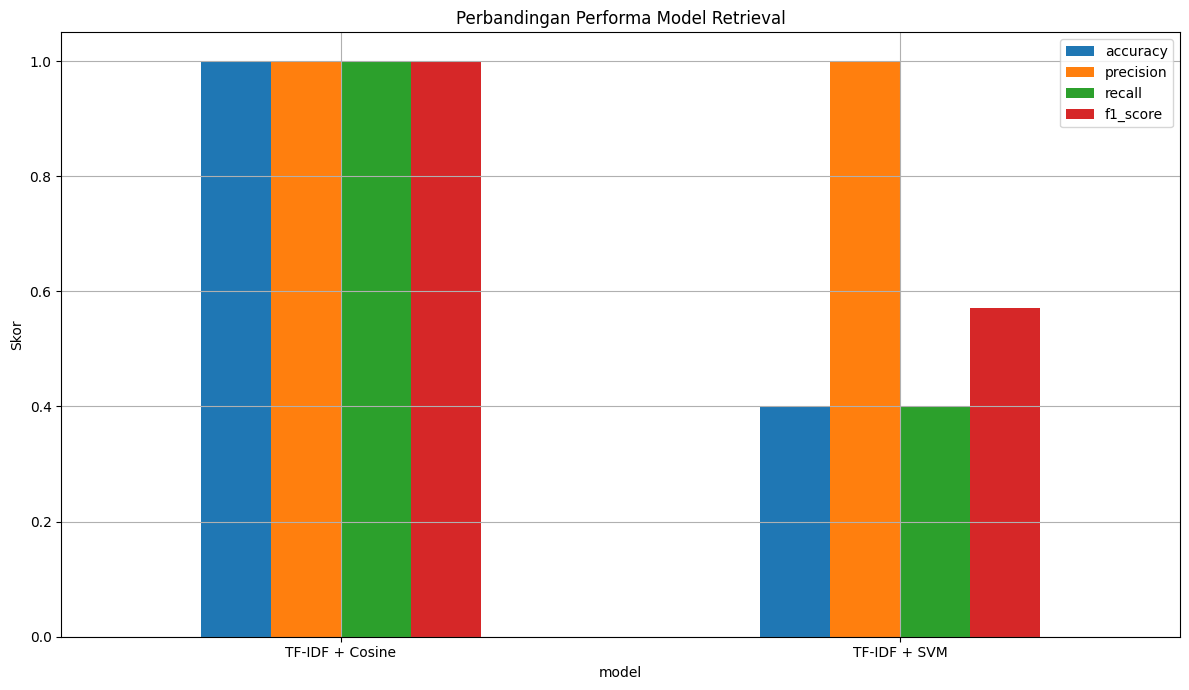


[SUKSES] Tahap 5 Selesai. Hasil evaluasi disimpan di folder 'data\eval'


In [10]:
def evaluate_model(predictions_file: str, ground_truth_file: str, model_name: str) -> Dict:
    """Mengevaluasi performa model dan mengembalikan metrik."""
    preds_df = pd.read_csv(predictions_file)
    with open(ground_truth_file, 'r') as f: gt_data = json.load(f)
    
    y_true, y_pred, error_cases = [], [], []

    for i, row in preds_df.iterrows():
        try: predicted_ids = json.loads(row['retrieved_case_ids'].replace("'", "\""))
        except: predicted_ids = []
        ground_truth_ids = gt_data[i]['ground_truth']
        
        is_correct = any(pid in ground_truth_ids for pid in predicted_ids)
        y_true.append(1); y_pred.append(1 if is_correct else 0)
        
        if not is_correct:
            error_cases.append({"query_id": i+1, "query": row['query'], "predicted": predicted_ids, "ground_truth": ground_truth_ids})
    return {"model": model_name, "accuracy": accuracy_score(y_true, y_pred), 
            "precision": precision_score(y_true, y_pred, zero_division=0), 
            "recall": recall_score(y_true, y_pred, zero_division=0), 
            "f1_score": f1_score(y_true, y_pred, zero_division=0), "errors": error_cases}

def run_stage_5_evaluation():
    """Menjalankan evaluasi untuk kedua model dan memvisualisasikan hasilnya."""
    print("\n" + "="*50 + "\nMemulai Tahap 5: Evaluasi Model\n" + "="*50)
    eval_folder = os.path.join(DATA_FOLDER, 'eval')
    
    gt_file = os.path.join(eval_folder, 'queries.json')
    cosine_preds_file = os.path.join(DATA_FOLDER, 'results', 'predictions_cosine.csv')
    svm_preds_file = os.path.join(DATA_FOLDER, 'results', 'predictions_svm.csv')
    
    metrics_cosine = evaluate_model(cosine_preds_file, gt_file, "TF-IDF + Cosine")
    metrics_svm = evaluate_model(svm_preds_file, gt_file, "TF-IDF + SVM")
    
    with open(os.path.join(eval_folder, 'error_cases_cosine.json'), 'w') as f: json.dump(metrics_cosine.pop('errors'), f, indent=4)
    with open(os.path.join(eval_folder, 'error_cases_svm.json'), 'w') as f: json.dump(metrics_svm.pop('errors'), f, indent=4)

    metrics_df = pd.DataFrame([metrics_cosine, metrics_svm])
    metrics_path = os.path.join(eval_folder, 'evaluation_metrics.csv')
    metrics_df.to_csv(metrics_path, index=False)
    
    print("--- Hasil Evaluasi ---")
    display(metrics_df)
    
    # Visualisasi
    fig_path = os.path.join(eval_folder, 'performance_comparison.png')
    metrics_df.set_index('model').plot(kind='bar', figsize=(12, 7), rot=0, grid=True)
    plt.title('Perbandingan Performa Model Retrieval')
    plt.ylabel('Skor')
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.show() # Tampilkan plot langsung di notebook
    
    print(f"\n[SUKSES] Tahap 5 Selesai. Hasil evaluasi disimpan di folder '{eval_folder}'")

# Jalankan Tahap 5
run_stage_5_evaluation()